# Import Stuff & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary
import warnings
import os
import sys
from tqdm import tqdm
import cv2


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
RESOLUTION = 64
block_frame = 8
frame_interval = 15

In [5]:
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

In [6]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    # transforms.Lambda(lambda x: x / 255.),
    transforms.Resize((RESOLUTION, RESOLUTION))
])


# Utils

In [7]:
def plot_image_from_list(__images, __labels, __count):
    plt.figure(figsize=(10, 10))
    for _i in range(__count[0] * __count[1]):
        plt.subplot(__count[0], __count[1], _i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        _img = __images[_i].to("cpu").numpy()
        plt.imshow(_img, cmap= "gray")
        plt.xlabel(__labels[_i])
    plt.show()

In [8]:
def plot_randomly_form_dataset(__dataset):
    images = []
    labels = []
    for _ in range(0, 25):
        index = torch.randint(0, len(__dataset), (1,)).item()
        image, label = __dataset[index]
        images.append(image[:,0].squeeze())
        labels.append(__dataset.label_id2str(label.item()))
    
    plot_image_from_list(images, labels, (5, 5))
        

In [9]:
def plot_sequence_form_dataset(__dataset, index):
    images = []
    labels = []
    for i in range(0, block_frame):
        image, label = __dataset[index]
        images.append(image[:,i].squeeze())
        labels.append(__dataset.label_id2str(label.item()))
    
    plot_image_from_list(images, labels, (1, block_frame))
        

In [44]:
def plot_randomly_form_dataset_model(__dataset, __model):
    images = []
    labels = []
    __model.to(device)
    for i in range(0, 25):
        index = torch.randint(0, len(__dataset), (1,)).item()
        image, label = __dataset[index]
        images.append(image[:,0].squeeze())
        result = model(image.unsqueeze(dim=0).to(device)).squeeze().cpu().argmax()
        
        labels.append(__dataset.label_id2str(label.item()) + " -> " + __dataset.label_id2str(result.item()))
 
    plot_image_from_list(images, labels, (5, 5))
        

# Dataset

In [11]:
# DATA_SOURCE = {
#     "Abuse": "E:\kaggle\input\crimeufcdataset\Anomaly_Dataset\Anomaly_Videos\Anomaly-Videos-Part-1\Abuse",
#     "Arrest": "E:\kaggle\input\crimeufcdataset\Anomaly_Dataset\Anomaly_Videos\Anomaly-Videos-Part-1\Arrest",
#     "Arson": "E:\kaggle\input\crimeufcdataset\Anomaly_Dataset\Anomaly_Videos\Anomaly-Videos-Part-1\Arson",
#     "Assault": "E:\kaggle\input\crimeufcdataset\Anomaly_Dataset\Anomaly_Videos\Anomaly-Videos-Part-1\Assault",
#     "Burglary": "E:\kaggle\input\crimeufcdataset\Anomaly_Dataset\Anomaly_Videos\Anomaly-Videos-Part-2\Burglary",
#     "Explosion": "E:\kaggle\input\crimeufcdataset\Anomaly_Dataset\Anomaly_Videos\Anomaly-Videos-Part-2\Explosion",
#     "Fighting": "E:\kaggle\input\crimeufcdataset\Anomaly_Dataset\Anomaly_Videos\Anomaly-Videos-Part-2\Fighting",
#     "Normal" : "E:\\kaggle\\input\\crimeufcdataset\\Anomaly_Dataset\\Anomaly_Videos\\Normal-Videos-Part-1"
# }

DATA_SOURCE = {
   "Abuse": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Abuse",
    "Arrest": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Arrest",
    "Arson": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Arson",
    "Assault": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Assault",
    "Burglary": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Burglary",
    "Explosion": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Explosion",
    "Fighting": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Fighting",   
    "RoadAccidents":"D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\RoadAccidents",
    "Robbery": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Robbery",
    "Shooting": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Shooting",
    "Shoplifting": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Shoplifting",
    "Stealing": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Stealing",
    "Vandalism": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Vandalism",
    "Normal": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Normal"
}


# DATA_SOURCE = {
#     "Abuse": "E:\kaggle\input\crimeufcdataset\Anomaly_Dataset\Anomaly_Videos\Anomaly-Videos-Part-1\Abusetest",
#     "Arrest": "E:\kaggle\input\crimeufcdataset\Anomaly_Dataset\Anomaly_Videos\Anomaly-Videos-Part-1\Arresttest",
# }



In [12]:
import os

# 파일 경로를 설정합니다.
directory_path = "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Abuse"

# 경로가 존재하는지 확인합니다.
if os.path.exists(directory_path):
    print("경로가 존재합니다.")
    # 디렉터리 내의 파일 목록을 출력합니다.
    print("디렉터리 내용:", os.listdir(directory_path))
else:
    print("지정된 경로를 찾을 수 없습니다.")


경로가 존재합니다.
디렉터리 내용: ['Abuse001_x264.mp4', 'Abuse002_x264.mp4', 'Abuse003_x264.mp4', 'Abuse004_x264.mp4', 'Abuse005_x264.mp4', 'Abuse006_x264.mp4', 'Abuse007_x264.mp4', 'Abuse008_x264.mp4', 'Abuse009_x264.mp4', 'Abuse010_x264.mp4']


In [13]:
class CrimeDataset(Dataset):
    def __init__(self, __train=True, __train_test_split=0.95, __random_state=42):
        torch.manual_seed(__random_state)
        
        self._data = []
        self._labels = []
        self._inclusion_probability = __train_test_split if __train else 1.0 - __train_test_split
        self._frame_interval = frame_interval
        
        print(f"Loading {'train' if __train else 'test' } dataset...")
        for label, data_path in DATA_SOURCE.items():
            print(f"Loading Label {label}...")
            for file in tqdm(os.listdir(data_path)):
                if file.endswith(".mp4") and torch.rand(1).item() <= self._inclusion_probability:
                    path = os.path.join(data_path, file)
                    data, labels = self._parse_file(path, label)
                    # print(data)
                    # print(labels)
                    # print(data[0].shape)
                    # print(len(data))
                    # print(len(labels))
                    
                    
                    
                    self._data.extend(data)
                    self._labels.extend(labels)
        print(f"Finished loading {'train' if __train else 'test' } dataset... Loaded  {len(self._data)} images.")
    
    def _parse_file(self, __path, __label):
        if not os.path.exists(__path):
            return [], []
        
        data = []
        labels = []
        
        cap = cv2.VideoCapture(__path)
        
        frames = []
        success, image = cap.read()
        while success:
            try:
                if True:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
                    Y, U, V = cv2.split(image)
                    image = transformer(Y)
                    frames.append(image)
                    
                    if len(frames) == block_frame:
                        stacked_frames = torch.stack(frames)
                        stacked_frames = stacked_frames.permute(1, 0, 2, 3)
                        data.append(stacked_frames)
                        labels.append(__label)
                        frames = frames[3:]
            except Exception as e:
                print(f"Error loading file {__path}: {e}")
            
            count = 0
            while success and count < self._frame_interval:
                success, image = cap.read()
                count += 1
                
        if len(frames) > 0 and len(frames) < block_frame:
            while len(frames) < block_frame:
                frames.append(frames[-1])
            stacked_frames = torch.stack(frames)
            stacked_frames = stacked_frames.permute(1, 0, 2, 3)
            data.append(stacked_frames)
            labels.append(__label)        
                
        return data, labels
        
    
    def label_str2id(self, __label):
        labels = DATA_SOURCE.keys()
        return list(labels).index(__label)

    def label_id2str(self, __label):
        labels = DATA_SOURCE.keys()
        return list(labels)[__label]
        
    def __len__(self):
        return len(self._labels)

    def __getitem__(self, __idx):
        data = self._data[__idx]
        label = self._labels[__idx]
        return data, torch.tensor([self.label_str2id(label)])

In [14]:
train_dataset = CrimeDataset(True)
test_dataset = CrimeDataset(False)

Loading train dataset...
Loading Label Abuse...


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Loading Label Arrest...


100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


Loading Label Arson...


100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


Loading Label Assault...


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


Loading Label Burglary...


100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


Loading Label Explosion...


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Loading Label Fighting...


100%|██████████| 9/9 [00:09<00:00,  1.04s/it]


Loading Label RoadAccidents...


100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


Loading Label Robbery...


100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


Loading Label Shooting...


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Loading Label Shoplifting...


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Loading Label Stealing...


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Loading Label Vandalism...


100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Loading Label Normal...


100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


Finished loading train dataset... Loaded  9982 images.
Loading test dataset...
Loading Label Abuse...


100%|██████████| 10/10 [00:00<?, ?it/s]


Loading Label Arrest...


100%|██████████| 10/10 [00:00<?, ?it/s]


Loading Label Arson...


100%|██████████| 9/9 [00:00<?, ?it/s]


Loading Label Assault...


100%|██████████| 10/10 [00:00<00:00, 20.27it/s]


Loading Label Burglary...


100%|██████████| 10/10 [00:00<?, ?it/s]


Loading Label Explosion...


100%|██████████| 10/10 [00:00<00:00, 13.66it/s]


Loading Label Fighting...


100%|██████████| 9/9 [00:00<?, ?it/s]


Loading Label RoadAccidents...


100%|██████████| 10/10 [00:00<00:00, 45.12it/s]


Loading Label Robbery...


100%|██████████| 10/10 [00:00<?, ?it/s]


Loading Label Shooting...


100%|██████████| 10/10 [00:00<?, ?it/s]


Loading Label Shoplifting...


100%|██████████| 9/9 [00:02<00:00,  4.21it/s]


Loading Label Stealing...


100%|██████████| 10/10 [00:00<00:00, 29.75it/s]


Loading Label Vandalism...


100%|██████████| 10/10 [00:00<?, ?it/s]


Loading Label Normal...


100%|██████████| 12/12 [00:00<00:00, 23.68it/s]

Finished loading test dataset... Loaded  496 images.


torch.Size([1, 8, 64, 64])


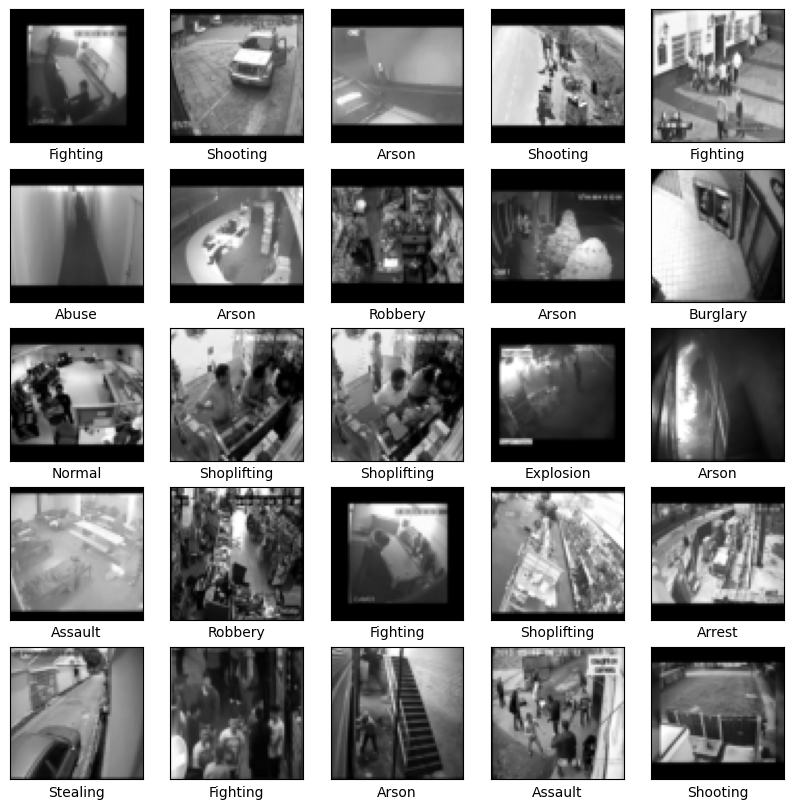

In [15]:
print(train_dataset._data[0].shape)
plot_randomly_form_dataset(train_dataset)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

9982
torch.Size([1, 8, 64, 64])
tensor([0])
torch.Size([1, 8, 64, 64])


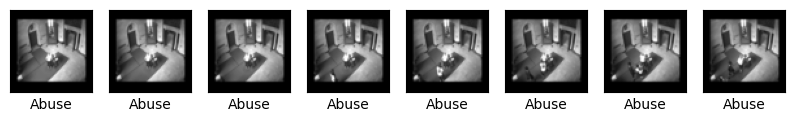

In [17]:
print(len(train_dataset))
# print(len(train_dataset._data))
# print(len(train_dataset._labels))
print(train_dataset._data[0].shape)
print(train_dataset[0][1])
print(train_dataset[3][0].shape)
plot_sequence_form_dataset(train_dataset, 4)

# Model

In [18]:
class CrimeModelCNN(nn.Module):
    def __init__(self):
        super(CrimeModelCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 64, kernel_size=3, padding="same")
        self.ReLU = nn.ReLU()
        self.max_pool1 = nn.MaxPool3d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, padding="same")
        self.max_pool2 = nn.MaxPool3d(2, 2)
        self.dropout2 = nn.Dropout(0.25)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, padding="same")
        self.max_pool3 = nn.MaxPool3d(2, 2)
        self.dropout3 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(256 * block_frame * block_frame, 256)
        self.dropout4 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        #print(x.shape)
        x = self.ReLU(x)
        #print(x.shape)
        x = self.max_pool1(x)
        #print(x.shape)
        x = self.dropout1(x)
        #print(x.shape)
        x = self.conv2(x)
        #print(x.shape)
        x = self.ReLU(x)
        #print(x.shape)
        x = self.max_pool2(x)
        #print(x.shape)
        x = self.dropout2(x)
        #print(x.shape)
        x = self.conv3(x)
        #print(x.shape)
        x = self.ReLU(x)
        #print(x.shape)
        x = self.max_pool3(x)
        #print(x.shape)
        x = self.dropout3(x)
        #print(x.shape)
        x = x.view(-1, 256 * block_frame * block_frame)
        #print(x.shape)
        x = self.fc1(x)
        #print(x.shape)
        #x = self.ReLU(x)
        #print(x.shape)
        #x = self.dropout4(x)
        #print(x.shape)
        return x
    
 

In [19]:
class CrimeModelLSTM(nn.Module):
    def __init__(self):
        super(CrimeModelLSTM, self).__init__()
        self.lstm1 = nn.LSTM(1, 8, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(8, 8, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(8, 4)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        x = self.fc(x)
        x = self.dropout(x)
        return x

In [20]:
# CNN과 LSTM을 동시에 사용하는 모델
class CrimeModel(nn.Module):
    def __init__(self):
        super(CrimeModel, self).__init__()
        self.cnn = CrimeModelCNN()
        self.lstm = CrimeModelLSTM()
        self.fc = nn.Linear(260, 14)  # Adjust the input size according to your concatenation axis


    def forward(self, x):
        x_cnn = x
        x_lstm = torch.reshape(x[:,:,0], (x.shape[0], RESOLUTION * RESOLUTION, 1))
        x_cnn = self.cnn(x_cnn)
        x_lstm = self.lstm(x_lstm)
        x_combined = torch.cat((x_cnn, x_lstm), dim=1)
        x = self.fc(x_combined)
#         return F.softmax(x, dim=1)
        return x

In [21]:
model = CrimeModel()
output = model(torch.rand(32, 1, 10, 64, 64))
print(output.shape)

torch.Size([32, 14])


# Training

In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [23]:
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): CrimeModel(
    (cnn): CrimeModelCNN(
      (conv1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
      (ReLU): ReLU()
      (max_pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout1): Dropout(p=0.25, inplace=False)
      (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
      (max_pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout2): Dropout(p=0.25, inplace=False)
      (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
      (max_pool3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout3): Dropout(p=0.4, inplace=False)
      (fc1): Linear(in_features=16384, out_features=256, bias=True)
      (dropout4): Dropout(p=0.5, inplace=False)
    )
    (lstm): CrimeModelLSTM(
      (lstm1): LSTM(1, 8, batch_first=True)
      (lstm2): LSTM(8, 8, batch_firs

In [24]:
NUM_EPOCHS = 5

In [25]:
for g in optimizer.param_groups:
    g['lr'] = 0.001

In [26]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  21374 KiB |  21376 KiB |  21383 KiB |   9728 B   |\n|       from large pool |  20480 KiB |  20480 KiB |  20480 KiB |      0 B   |\n|       from small pool |    894 KiB |    896 KiB |    903 KiB |   9728 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |  21374 KiB |  21376 KiB |  21383 KiB |   9728 B   |\n|       from large pool |  20480 KiB |  20480 KiB |

In [27]:
total_batches = len(train_loader)
for epoch in range(NUM_EPOCHS):
    model.train()
    _total_correct = 0
    
    print(f"Epoch : {epoch}...")
    
    for batch_idx, (data, label) in enumerate(train_loader):
        print(f"Batch : {batch_idx + 1}/{total_batches}\t\t", end="\r")
        
        data = data.to(device)
        label = label.to(device)
        
        preds = model(data)
        
        # print(preds.shape, label.shape)
        # print(label)
        
        loss = criterion(preds, label.squeeze())
        optimizer.zero_grad()

        loss.backward()
        
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print(f"Loss: {loss.item()}, Batch: {batch_idx + 1}/{total_batches}")

Epoch : 0...
Loss: 2.646458625793457, Batch: 1/156
Loss: 2.5666322708129883, Batch: 11/156
Loss: 2.2435545921325684, Batch: 21/156
Loss: 1.960221529006958, Batch: 31/156
Loss: 1.420676350593567, Batch: 41/156
Loss: 1.3306840658187866, Batch: 51/156
Loss: 1.0554205179214478, Batch: 61/156
Loss: 0.9991948008537292, Batch: 71/156
Loss: 0.7718634009361267, Batch: 81/156
Loss: 0.5321776866912842, Batch: 91/156
Loss: 0.6372449398040771, Batch: 101/156
Loss: 0.48403698205947876, Batch: 111/156
Loss: 0.33512255549430847, Batch: 121/156
Loss: 0.2468981146812439, Batch: 131/156
Loss: 0.11659944802522659, Batch: 141/156
Loss: 0.28511664271354675, Batch: 151/156
Epoch : 1...156		
Loss: 0.3425363302230835, Batch: 1/156
Loss: 0.13841676712036133, Batch: 11/156
Loss: 0.18661734461784363, Batch: 21/156
Loss: 0.16170631349086761, Batch: 31/156
Loss: 0.22935377061367035, Batch: 41/156
Loss: 0.1455765962600708, Batch: 51/156
Loss: 0.25835859775543213, Batch: 61/156
Loss: 0.19263748824596405, Batch: 71/15

In [28]:
torch.save(model, "model.pt")

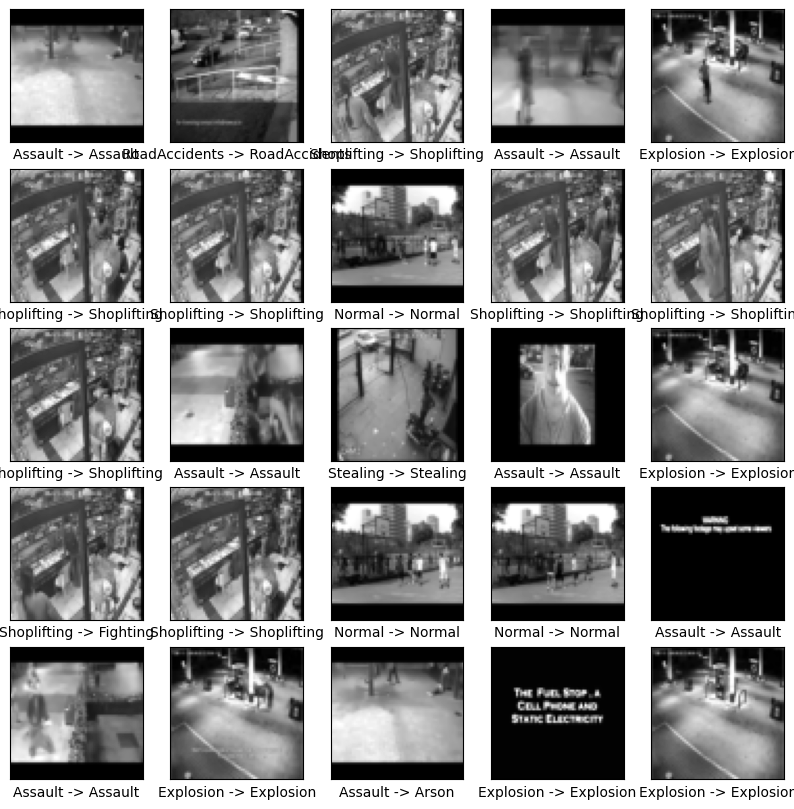

In [45]:
plot_randomly_form_dataset_model(test_dataset, model)

In [ ]:
print(os.getcwd())

In [46]:
model = torch.load("model.pt")
model.to(device)
model.eval()  # Set the model to evaluation mode

def calculate_accuracy(model, data_loader, device):
    correct = 0
    total = 0

    with torch.no_grad():  # No need to compute gradients for evaluation
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the device
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            for i in range(len(labels)):
                if (predicted[i] == labels[i]):
                    correct += 1
            
            print(labels.squeeze())
            print("predicted = {},\n total  = {}, correct = {}".format(predicted,total,correct))
            
            # print(outputs)

    accuracy = 100 * correct / total
    return accuracy

# Calculate accuracy on the test dataset
accuracy = calculate_accuracy(model, test_loader, device)
print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')


tensor([13, 10, 10, 10,  7,  5, 13, 10, 10, 10, 10, 10, 10,  5, 10, 13,  5,  3,
         7,  7, 13, 10, 10,  5, 11, 10,  5,  3, 10, 10, 10, 13, 10, 10, 10, 10,
        11, 11, 11, 11, 10,  7,  5, 10, 11, 13,  5, 10, 10, 10, 11,  5,  3,  5,
        13,  3, 10, 11, 10,  3,  5, 11, 10,  5], device='cuda:0')
predicted = tensor([13, 10, 10, 10,  7,  5, 13, 10, 10, 10, 10, 10, 10,  5, 10, 13,  5,  3,
         7,  7, 13, 10, 10,  5, 11, 10,  5,  3, 10, 10, 10, 13, 10, 10, 10, 10,
        11, 11, 11, 11, 10,  7,  5, 10, 11, 13,  5, 10, 10, 10, 11,  5,  3,  5,
        13,  3, 10, 11, 10,  3,  5, 11, 10,  5], device='cuda:0'),
 total  = 64, correct = 64
tensor([ 3, 10, 10, 10,  3, 10, 13,  5,  5, 10, 10,  5, 10, 10,  5,  3,  5, 13,
        10,  3,  5,  5, 10, 13,  5,  5, 10, 10, 13, 10, 11, 10, 10, 10, 10,  7,
         5,  5, 10,  5, 10, 10, 10,  7, 10, 13, 10, 10, 13, 10,  5, 10, 10, 10,
         3, 10, 10, 11, 10, 10, 10,  3, 11, 10], device='cuda:0')
predicted = tensor([ 3, 10, 10, 10,  3, 10